# Double Well Potential with MCMC

Consider the double well potential,

$$
V(x) = ax^4 - 2x^2 + \frac{1}{a}
$$

where $x$ is the position of the particle, and we set $m = \hbar = 1$ and $a = 0.4$. See Refs. [1, 2] for discussions of similar problems.

Use the path integral formulation with imaginary time $\tau$,

$$
Z = \int Dx(\tau) \exp \left[ -\frac{1}{\hbar} \int_0^{t_b} L_E(x(\tau))d\tau \right]
$$

$$
= \lim_{\delta\tau \to 0} \int \cdots \int dx_0 \cdots dx_{N-1} \left( \frac{2\pi\hbar\delta\tau}{m} \right)^{-\frac{N}{2}} \exp \left[ -\frac{1}{\hbar} \sum_{i=1}^{N} \frac{m}{2\delta\tau} (x_i - x_{i-1})^2 + \delta\tau V\left(\frac{x_{i-1} + x_i}{2}\right) \right]
$$

where $L_E(x(\tau)) = \frac{m}{2} \left( \frac{dx}{d\tau} \right)^2 + V(x(\tau))$ is the Euclidean Lagrangian, imaginary time is discretized with $N$ increments, $\tau_a = 0$, and $\tau_b = N\delta\tau = \hbar\beta$. So the probability of a given path $(x_0, x_1, \ldots, x_{N-1})$ is

$$
p(x_0, \ldots, x_{N-1}) \propto \exp \left[ -\frac{1}{\hbar} \sum_{i=1}^{N} \frac{m}{2\eta} (x_i - x_{i-1})^2 + \eta V\left(\frac{x_{i-1} + x_i}{2}\right) \right]
$$


## Problem A

Evaluate the ground state energy and probability distribution of the particle using Markov chain Monte Carlo with the Metropolis-Hastings algorithm in the large-$\tau_b$ (imaginary time) limit. Describe your strategy for determining $\tau$, the initial conﬁguration, burn-in steps, hit size, number of sweeps, and thinning (if any).

### Imports

Let's begin importing all the necessary packages for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import numba # to accelerate the code via JIT

### Constants

In [2]:
# Constants given in the problem
SWEEPS = 80000
H = 1
M = 1
TAU = 3000
DELTATAU = 0.1
NTAU = int(TAU/DELTATAU)
HITSIZE = 0.1
ALPHA = 0.4  # Alpha for the double well potential
BURNIN = 40000
THINNING = 50 # consider every 50th sample for the histogram to reduce correlation

# Range for x values
XLOW = -4
XHIGH = 4
NXBINS = 400
DELTAX = (XHIGH - XLOW) / NXBINS
prob_histogram = np.zeros(NXBINS)
x_bins = np.linspace(XLOW, XHIGH, NXBINS + 1)

### Initial Configuration

In previous assignments, we used either a "cold start" (where all values in a path are set to a constant, such as zero) or a "hot start" (where all values in a path are set to random values). In this case, we will use a more intelligent approach, where we set the initial configuration to be randomly chosen values from either $\frac{1}{\sqrt{\alpha}}$ or $-\frac{1}{\sqrt{\alpha}}$, which are the two minima of the potential. This way, we can start the simulation closer to the minima, where it's more likely to find the particle.

In [3]:
# Instead of doing initialization with zeros, let's initialize randomly with either 1/sqrt(alpha) or -1/sqrt(alpha)
x_path = np.random.choice([-1/np.sqrt(ALPHA), 1/np.sqrt(ALPHA)], NTAU)

### Double Well Potential

Let's define a function to describe the double well potential.

In [4]:
@numba.jit
def V_double_well(x, alpha):
    """
    Double well potential function V(x) = alpha * x^4 - 2 * x^2 + 1/alpha
    """
    return alpha * x**4 - 2 * x**2 + 1/alpha

### Markov Chain Monte Carlo with Metropolis-Hastings Algorithm

Now, we define some helper functions that allow us to implement MCMC with the Metropolis-Hastings algorithm in imaginary time.

The `vary_path` function takes a path and returns a new path with a random value changed. This is the "hit" step in the Metropolis-Hastings algorithm.

The `action` function computes the action for a given slice of the path.

The `delta_action` function computes the change in action $\delta S$ for a proposed path change at a given slice.

The `total_action` function takes a path and returns the total action of the path.

In [5]:
@numba.jit
def vary_path(x_current, hit_size, xlow, xhigh):
    """
    Proposes a new path by varying the current path within the range of [xlow, xhigh].
    """
    x_prime = x_current + np.random.uniform(-hit_size, hit_size)
    while x_prime > xhigh or x_prime < xlow:
        x_prime = x_current + np.random.uniform(-hit_size, hit_size)
    return x_prime

@numba.jit
def action(x_left, x_right, m, delta_tau, alpha):
    """
    Computes the action for a given slice of the path.
    """
    kinetic_term = 0.5 * m * ((x_right - x_left) / delta_tau)**2
    potential_term = V_double_well(0.5 * (x_left + x_right), alpha)
    return delta_tau * (kinetic_term + potential_term)

@numba.jit
def delta_action(x_path, x_prime, i, m, delta_tau, alpha, n_tau):
    """
    Computes the change in action delta S for a proposed path change at position i.
    """
    x_left = x_path[i-1]
    x_right = x_path[(i+1) % n_tau]  # Using modulo for periodic boundary condition
    S_old = action(x_left, x_path[i], m, delta_tau, alpha) + action(x_path[i], x_right, m, delta_tau, alpha)
    S_new = action(x_left, x_prime, m, delta_tau, alpha) + action(x_prime, x_right, m, delta_tau, alpha)
    return S_new - S_old

@numba.jit
def total_action(x_path, m, delta_tau, alpha, nx_bins):
    """
    Computes the total action for the entire path.
    """
    path_action = 0
    for i in range(-1, nx_bins - 1):
        path_action += action(x_path[i], x_path[i+1], m, delta_tau, alpha)

    return path_action

Finally, we can define a function called `MCMC` which implements the Metropolis-Hastings algorithm.

In [6]:
@numba.jit
def MCMC(x_path, m, delta_tau, alpha, hit_size, xlow, xhigh, n_tau):
    """
    Performs a single sweep of the Metropolis-Hastings algorithm over all time slices of the path.
    """
    for i in range(n_tau):
        x_prime = vary_path(x_path[i], hit_size, xlow, xhigh)
        dS = delta_action(x_path, x_prime, i, m, delta_tau, alpha, n_tau)
        if dS <= 0 or (np.random.random() < np.exp(-dS)):
            x_path[i] = x_prime
    
    # Update the histogram of the path positions
    hist, _ = np.histogram(x_path, bins=x_bins)
    return hist

### Energy Calculation

At each sweep of MCMC, it is helpful to calculate the energy of the particle. This is done by first calculating the Hamiltonian matrix, and then using the expectation value of the Hamiltonian to calculate the energy. Let's define functions for these tasks.

In [7]:
@numba.jit
def Hamiltonian(nx_bins, x_bins, delta_x, alpha):
    """
    Returns the H matrix for the Hamiltonian.
    """
    H = np.zeros((nx_bins + 1, nx_bins + 1))
    for i in range(nx_bins + 1):
        for j in range(nx_bins + 1):
            # kinetic part
            H[i, j] = -(0.5 / delta_x**2) * ((i + 1 == j) - 2 * (i == j) + (i - 1 == j)) 
            # potential part
            H[i, j] += V_double_well(x_bins[i], alpha) * (i == j)

    return H

@numba.jit
def ground_state_energy(prob_histogram_normalized, delta_x, alpha):
    """
    Returns the ground state energy from the Hamiltonian and the probability distribution.
    """
    K = np.real((1 / 2)*np.sum(delta_x * np.diff(np.sqrt(prob_histogram_normalized))*np.diff(np.sqrt(prob_histogram_normalized)) / delta_x**2))
    V = np.sum(prob_histogram_normalized * V_double_well(x_bins[:-1], alpha)) * delta_x
    return K + V

### Running the MCMC Simulation

Now that we have all the necessary functions, we can run the MCMC simulation.

In [8]:
# Running the MCMC simulation
energy_values = []
action_values = []
hists = []
energy_calculation_interval = 100 # Calculate the ground state energy every 100 sweeps

for sweep in tqdm(range(SWEEPS), desc='MCMC Sweeps'):
    hist = MCMC(x_path, M, DELTATAU, ALPHA, HITSIZE, XLOW, XHIGH, NTAU)
    if sweep % THINNING == 0:
        prob_histogram += hist
        hists.append(hist)

        if sweep % energy_calculation_interval == 0 and sweep != 0: # Calculate the ground state energy every energy_calculation_interval sweeps
            prob_histogram_normalized = prob_histogram / np.sum(prob_histogram) / DELTAX
            energy_values.append(ground_state_energy(prob_histogram_normalized, DELTAX, ALPHA))
            action_values.append(total_action(x_path, M, DELTATAU, ALPHA, NXBINS))

MCMC Sweeps: 100%|██████████| 80000/80000 [02:37<00:00, 506.34it/s]


### Probability Histogram

Before plotting the probability distribution, we need to only consider the probability history after the burn-in steps. Then, we need to normalize the probability history to obtain the probability distribution.

In [9]:
# Take only the values after burn-in
prob_histogram = np.sum(hists[BURNIN//THINNING:], axis=0)

# Normalize the probability histogram
prob_histogram_normalized = prob_histogram / np.sum(prob_histogram) / DELTAX

# Check the normalization of the probability histogram
print(f'Probability normalization: {np.sum(prob_histogram_normalized) * DELTAX:.3f}')

Probability normalization: 1.000


We can then plot the probability distribution

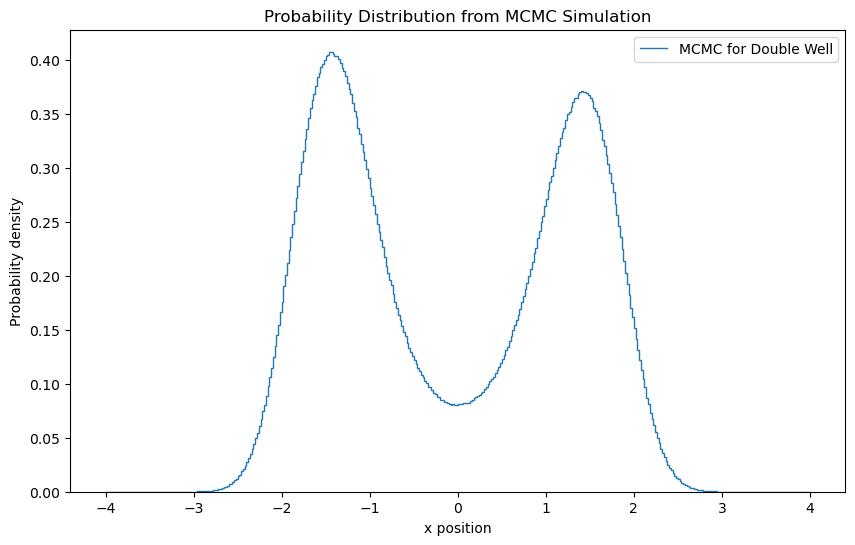

In [10]:
# Plotting the probability distribution
plt.figure(figsize=(10, 6))
plt.stairs(prob_histogram_normalized, x_bins, label='MCMC for Double Well')
plt.title('Probability Distribution from MCMC Simulation')
plt.xlabel('x position')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### Plotting the Energy over the Number of Sweeps

We can also plot the energy over the number of sweeps to see how the energy converges. This plot can help better understand the convergence of the simulation, and allow us to pick a good value for the number of sweeps, the burn-in steps, and the hit size.

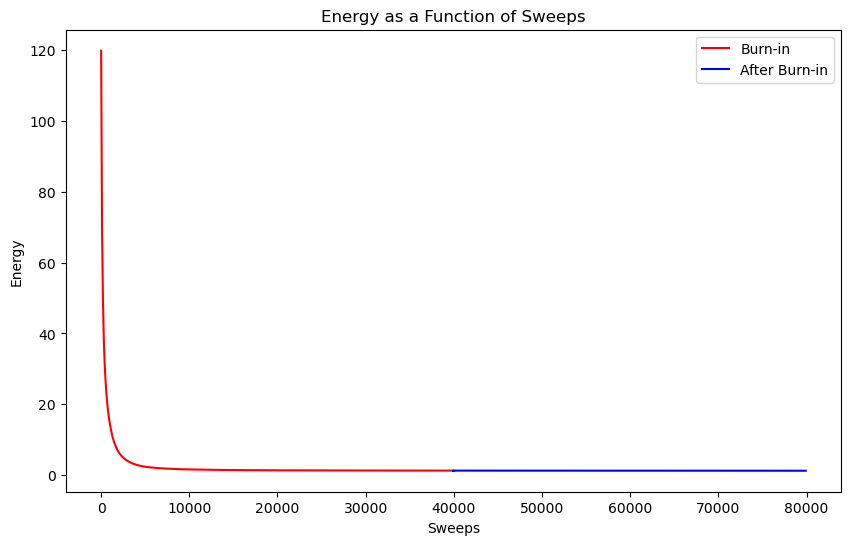

In [11]:
# Plot the energy as a function of the number of sweeps
plt.figure(figsize=(10, 6))
plt.plot(range(1, BURNIN, energy_calculation_interval), energy_values[:BURNIN//energy_calculation_interval], label='Burn-in', color='red')
plt.plot(range(BURNIN, SWEEPS, energy_calculation_interval), energy_values[BURNIN//energy_calculation_interval - 1:], label='After Burn-in', color='blue')
plt.plot([BURNIN - energy_calculation_interval, BURNIN], [energy_values[BURNIN//energy_calculation_interval-1], energy_values[BURNIN//energy_calculation_interval-1]], color='blue')
plt.title('Energy as a Function of Sweeps')
plt.xlabel('Sweeps')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Plotting the Action over the Number of Sweeps

We can also plot the action over the number of sweeps to see how the action converges.

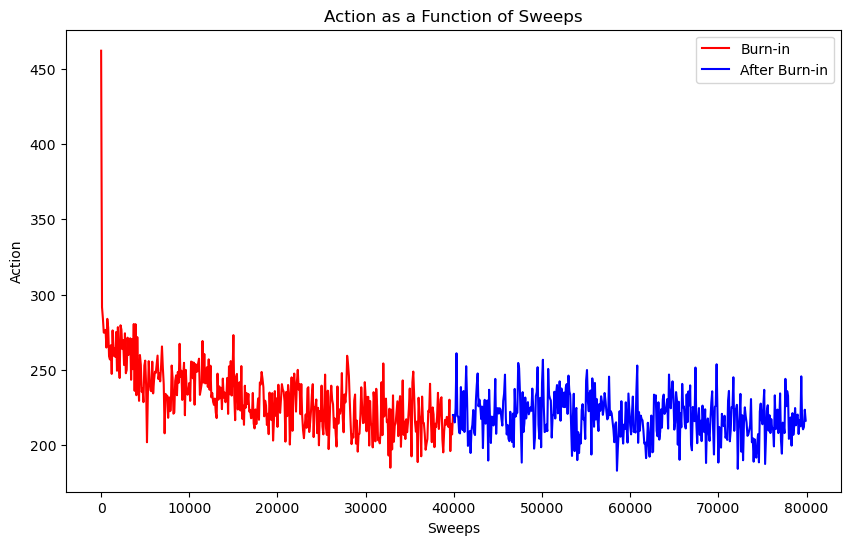

In [12]:
# Plot the action as a function of the number of sweeps
plt.figure(figsize=(10, 6))
plt.plot(range(1, BURNIN, energy_calculation_interval), action_values[:BURNIN//energy_calculation_interval], label='Burn-in', color='red')
plt.plot(range(BURNIN, SWEEPS, energy_calculation_interval), action_values[BURNIN//energy_calculation_interval - 1:], label='After Burn-in', color='blue')
plt.plot([BURNIN - energy_calculation_interval, BURNIN], [action_values[BURNIN//energy_calculation_interval -1], action_values[BURNIN//energy_calculation_interval -1]], color='blue')
plt.title('Action as a Function of Sweeps')
plt.xlabel('Sweeps')
plt.ylabel('Action')
plt.legend()
plt.show()

### Evaluating the Ground-State Energy

Finally, we can evaluate the ground-state energy by taking the average of the energy after the burn-in steps.

There are two methods in which this can be done:

#### Method 1: Using the Expected Value of the Hamiltonian

The expected value of the Hamiltonian is given by

$$\langle H \rangle = \frac{\langle \psi | H | \psi \rangle}{\langle \psi | \psi \rangle} $$

where $H$ is the Hamiltonian, and $| \psi \rangle$ is the wave function.

In [13]:
# Use the Hamiltonian and the probability distribution to find the ground state energy
# based on the expectation value of the Hamiltonian matrix
H = Hamiltonian(NXBINS, x_bins, DELTAX, ALPHA)
E_ground = np.sum(np.sqrt(prob_histogram_normalized) @ H[:-1, :-1] @ np.sqrt(prob_histogram_normalized)) * DELTAX
# Since the wavefunction for ground state is real and positive, the square root of the PDF can be used

print("[Method 1] Ground state energy from MCMC simulation:", E_ground)

[Method 1] Ground state energy from MCMC simulation: 1.246906097866323


#### Method 2: By Using $\langle E\rangle = \langle K\rangle + \langle V\rangle$

The mean potential energy $\langle V\rangle$ is given by

$$\langle V\rangle = \int \frac{1}{2}x^2 P_t(x) dx.$$

The mean kinetic energy $\langle K\rangle$ is given by

$$\langle K\rangle = \int \bar{\psi}(x) \left(- \frac{\hbar^2}{2} \frac{\partial^2}{\partial x^2}\right) \psi(x) dx = \frac{\hbar^2}{2} \int \left|\frac{\partial\psi}{\partial x}\right|^2  dx$$

And therefore, the mean energy is given by

$$\langle E\rangle = \langle K\rangle + \langle V\rangle$$

In [14]:
# Alternatively, calculate the ground state energy by doing <K> + <V>
K = np.real((1 / 2)*np.sum(DELTAX * np.diff(np.sqrt(prob_histogram_normalized))*np.diff(np.sqrt(prob_histogram_normalized)) / DELTAX**2))
V = np.sum(prob_histogram_normalized * V_double_well(x_bins[:-1], ALPHA)) * DELTAX
E_ground = K + V

print("[Method 2] Ground state energy from MCMC simulation:", E_ground)

[Method 2] Ground state energy from MCMC simulation: 1.2469060978662847


### Describe Your Strategy for Determining $\tau$, the Initial Conﬁguration, Burn-in Steps, Hit Size, Number of Sweeps, and Thinning (if any)

#### Determining $\tau$

The value of $\tau$ is determined by the number of sweeps. The number of sweeps is determined by the convergence of the energy and action. We can start with a small value of $\tau$ and increase it until the energy and action converge.

#### Initial Conﬁguration

The initial configuration is set to be randomly chosen values from either $\frac{1}{\sqrt{\alpha}}$ or $-\frac{1}{\sqrt{\alpha}}$, which are the two minima of the potential. This way, we can start the simulation closer to the minima, where it's more likely to find the particle.

#### Burn-in Steps

The burn-in steps are determined by the convergence of the energy and action. We can start with a small number of burn-in steps and use the plots of the energy and action to determine when the simulation has converged. We choose the burn-in steps to help avoid the transient behavior of the simulation.

#### Hit Size

TBA

#### Number of Sweeps

TBA

#### Thinning

TBA

## Problem B

Plot the ground state probability distribution and compare it with the expected form.

### Expected Form of the Ground State Probability Distribution

We can use the results of previous assignments to compute the expected form of the ground state probability distribution. This can be done by finding the eigenvectors of the Hamiltonian matrix using `scipy.linalg.eig` and sorting the eigenvectors by their corresponding eigenvalues to take the ground state eigenvector.

First, let's compute the Hamiltonian matrix.

In [15]:
BOXSIZE = 8
ND = 600
DELTAX = BOXSIZE / ND
x = np.linspace(-BOXSIZE / 2, BOXSIZE / 2, ND + 1)

H = Hamiltonian(ND, x, DELTAX, ALPHA)
# print the first 4x4 elements of H
print('First 4x4 elements of H:')
print(H[:4,:4])

First 4x4 elements of H:
[[ 5697.9        -2812.5            0.             0.        ]
 [-2812.5         5696.75445595 -2812.5            0.        ]
 [    0.         -2812.5         5695.62176328 -2812.5       ]
 [    0.             0.         -2812.5         5694.50183142]]


Then, we can use `scipy.linalg.eig` to find the eigenvectors of the Hamiltonian matrix.

The eigenvalue corresponding to the ground state is the smallest eigenvalue, and the eigenvector corresponding to the ground state is the eigenvector corresponding to the smallest eigenvalue.

In [16]:
def ground_state(H):
    """
    Returns the ground state energy and wave function.
    """
    Es, psis = scipy.linalg.eig(H)
    idx = np.argsort(Es)
    Es = Es[idx]
    psis = psis[:, idx]
    return np.real(Es[0]), psis[:, 0]

E_ground, psi_0 = ground_state(H)
# Find the ground state probability distribution
prob = np.abs(psi_0)**2
prob /= np.sum(prob) * DELTAX

print("Expected ground state energy:", E_ground)

Expected ground state energy: 1.2344772371011157


Finally, we can plot the ground state probability distribution and compare it with the expected form.

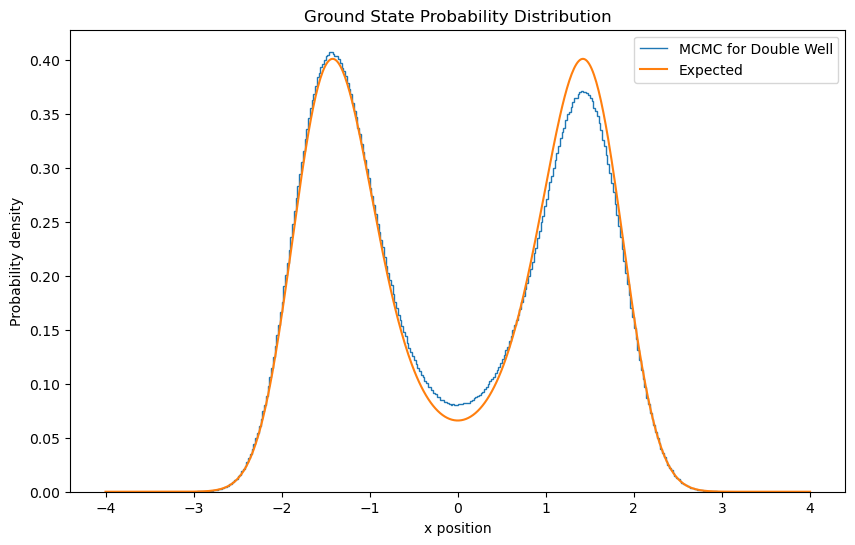

In [17]:
# Plot the ground state probability distribution and compare with MCMC result
plt.figure(figsize=(10, 6))
plt.stairs(prob_histogram_normalized, x_bins, label='MCMC for Double Well')
plt.plot(x, prob, label='Expected')
plt.title('Ground State Probability Distribution')
plt.xlabel('x position')
plt.ylabel('Probability density')
plt.legend()
plt.show()

## Problem C

Calculate the energy and probability distribution of the particle from the same simulation code for a smaller value of $\tau_b$. What is the expected probability distribution in this case? What does this correspond to in terms of a statistical mechanics interpretation?

### Solution

We can re-run the MCMC simulation for a smaller value of $\tau_b$, as follows.

MCMC Sweeps: 100%|██████████| 80000/80000 [00:15<00:00, 5121.03it/s]


Probability normalization: 1.000


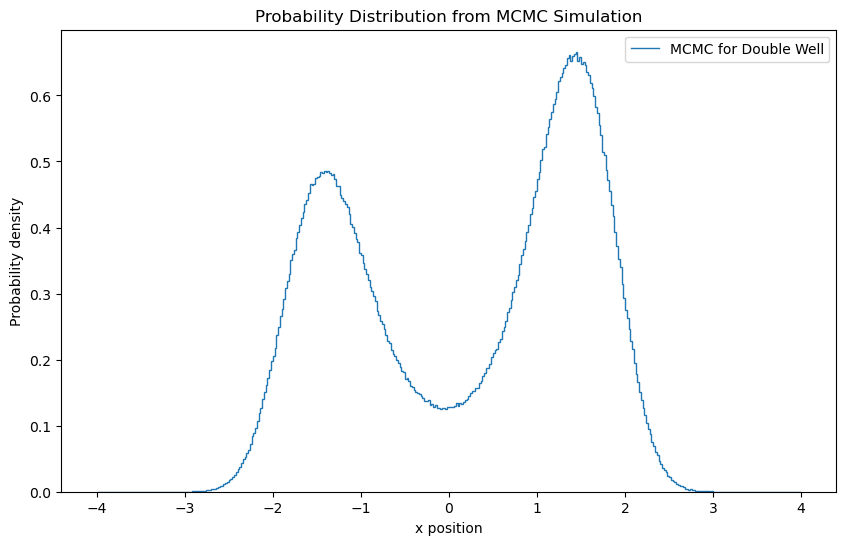

In [18]:
TAU_NEW = 300
NTAU_NEW = int(TAU_NEW/DELTATAU)
x_path = np.random.choice([-1/np.sqrt(ALPHA), 1/np.sqrt(ALPHA)], NTAU_NEW)

# Running the MCMC simulation
energy_values = []
action_values = []
hists = []
energy_calculation_interval = 100 # Calculate the ground state energy every 100 sweeps

for sweep in tqdm(range(SWEEPS), desc='MCMC Sweeps'):
    hist = MCMC(x_path, M, DELTATAU, ALPHA, HITSIZE, XLOW, XHIGH, NTAU_NEW)
    if sweep % THINNING == 0:
        prob_histogram += hist
        hists.append(hist)

        if sweep % energy_calculation_interval == 0 and sweep != 0: # Calculate the ground state energy every energy_calculation_interval sweeps
            prob_histogram_normalized = prob_histogram / np.sum(prob_histogram) / DELTAX
            energy_values.append(ground_state_energy(prob_histogram_normalized, DELTAX, ALPHA))
            action_values.append(total_action(x_path, M, DELTATAU, ALPHA, NXBINS))

# Take only the values after burn-in
prob_histogram = np.sum(hists[BURNIN//THINNING:], axis=0)

# Normalize the probability histogram
prob_histogram_normalized = prob_histogram / np.sum(prob_histogram) / DELTAX

# Check the normalization of the probability histogram
print(f'Probability normalization: {np.sum(prob_histogram_normalized) * DELTAX:.3f}')

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
plt.stairs(prob_histogram_normalized, x_bins, label='MCMC for Double Well')
plt.title('Probability Distribution from MCMC Simulation')
plt.xlabel('x position')
plt.ylabel('Probability density')
plt.legend()
plt.show()

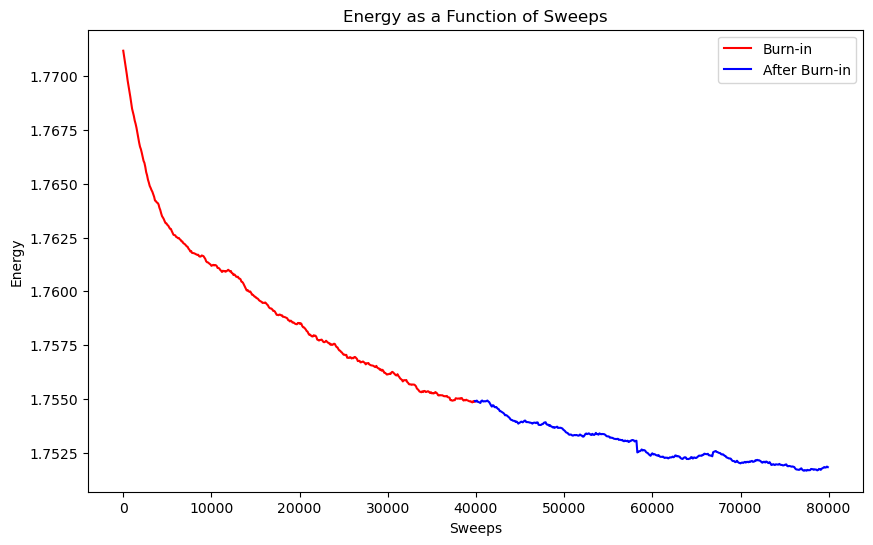

In [19]:
# Plot the energy as a function of the number of sweeps
plt.figure(figsize=(10, 6))
plt.plot(range(1, BURNIN, energy_calculation_interval), energy_values[:BURNIN//energy_calculation_interval], label='Burn-in', color='red')
plt.plot(range(BURNIN, SWEEPS, energy_calculation_interval), energy_values[BURNIN//energy_calculation_interval - 1:], label='After Burn-in', color='blue')
plt.plot([BURNIN - energy_calculation_interval, BURNIN], [energy_values[BURNIN//energy_calculation_interval-1], energy_values[BURNIN//energy_calculation_interval-1]], color='blue')
plt.title('Energy as a Function of Sweeps')
plt.xlabel('Sweeps')
plt.ylabel('Energy')
plt.legend()
plt.show()

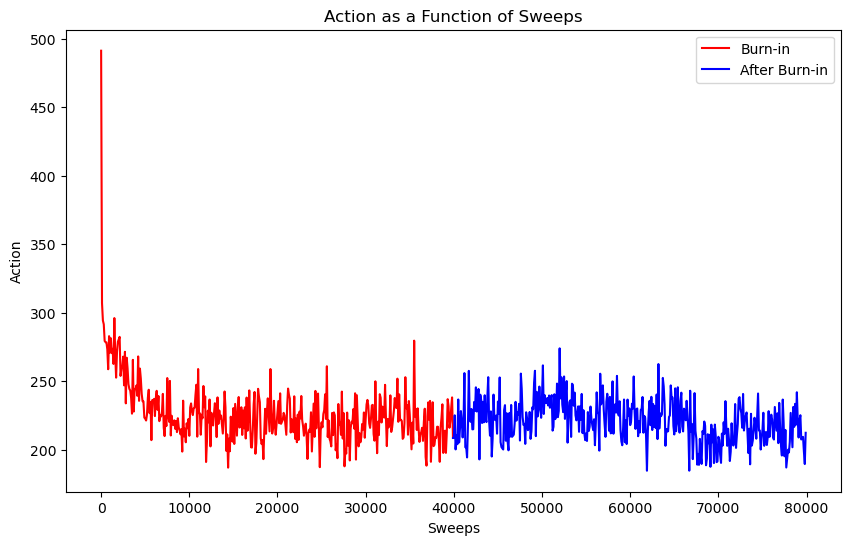

In [20]:

# Plot the action as a function of the number of sweeps
plt.figure(figsize=(10, 6))
plt.plot(range(1, BURNIN, energy_calculation_interval), action_values[:BURNIN//energy_calculation_interval], label='Burn-in', color='red')
plt.plot(range(BURNIN, SWEEPS, energy_calculation_interval), action_values[BURNIN//energy_calculation_interval - 1:], label='After Burn-in', color='blue')
plt.plot([BURNIN - energy_calculation_interval, BURNIN], [action_values[BURNIN//energy_calculation_interval -1], action_values[BURNIN//energy_calculation_interval -1]], color='blue')
plt.title('Action as a Function of Sweeps')
plt.xlabel('Sweeps')
plt.ylabel('Action')
plt.legend()
plt.show()

In [21]:
# Use the Hamiltonian and the probability distribution to find the energy
# based on the expectation value of the Hamiltonian matrix
H = Hamiltonian(NXBINS, x_bins, DELTAX, ALPHA)
E_ground = np.sum(np.sqrt(prob_histogram_normalized) @ H[:-1, :-1] @ np.sqrt(prob_histogram_normalized)) * DELTAX
# Since the wavefunction for ground state is real and positive, the square root of the PDF can be used

print("[Method 1] Energy from MCMC simulation:", E_ground)

# Alternatively, calculate the state energy by doing <K> + <V>
K = np.real((1 / 2)*np.sum(DELTAX * np.diff(np.sqrt(prob_histogram_normalized))*np.diff(np.sqrt(prob_histogram_normalized)) / DELTAX**2))
V = np.sum(prob_histogram_normalized * V_double_well(x_bins[:-1], ALPHA)) * DELTAX
E_ground = K + V

print("[Method 2] Energy from MCMC simulation:", E_ground)

[Method 1] Energy from MCMC simulation: 1.8896844059327078
[Method 2] Energy from MCMC simulation: 1.8896844059327247


### What does this correspond to in terms of a statistical mechanics interpretation?

TBA

## Bibliography

[1] S. Mittal, M. J. Westbroek, P. R. King, and D. D. Vvedensky, “Path integral Monte Carlo method for the quantum anharmonic oscillator”, [Eur. J. Phys. 41, 055401 (2020)](https://doi.org/10.1088/1361-6404/ab9a66).


[2] R. Rodgers and L. Raes, *Monte Carlo simulations of harmonic and anharmonic oscillators in discrete Euclidean time*, DESY Summer Student Programme (2014).